# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 16:47 - loss: 0.6952

  30/1875 [..............................] - ETA: 3s - loss: 0.5566   

  59/1875 [..............................] - ETA: 3s - loss: 0.4762

  81/1875 [>.............................] - ETA: 3s - loss: 0.4415

 105/1875 [>.............................] - ETA: 3s - loss: 0.4152

 127/1875 [=>............................] - ETA: 3s - loss: 0.3972

 154/1875 [=>............................] - ETA: 3s - loss: 0.3798

 178/1875 [=>............................] - ETA: 3s - loss: 0.3671

 205/1875 [==>...........................] - ETA: 3s - loss: 0.3552

 234/1875 [==>...........................] - ETA: 3s - loss: 0.3443

 258/1875 [===>..........................] - ETA: 3s - loss: 0.3363

 286/1875 [===>..........................] - ETA: 3s - loss: 0.3281

 314/1875 [====>.........................] - ETA: 3s - loss: 0.3208

 344/1875 [====>.........................] - ETA: 2s - loss: 0.3137

 375/1875 [=====>........................] - ETA: 2s - loss: 0.3072

 405/1875 [=====>........................] - ETA: 2s - loss: 0.3014

 432/1875 [=====>........................] - ETA: 2s - loss: 0.2967

 461/1875 [======>.......................] - ETA: 2s - loss: 0.2919

 490/1875 [======>.......................] - ETA: 2s - loss: 0.2875

 517/1875 [=======>......................] - ETA: 2s - loss: 0.2837

 546/1875 [=======>......................] - ETA: 2s - loss: 0.2798

 573/1875 [========>.....................] - ETA: 2s - loss: 0.2764

 599/1875 [========>.....................] - ETA: 2s - loss: 0.2734

 626/1875 [=========>....................] - ETA: 2s - loss: 0.2703

 655/1875 [=========>....................] - ETA: 2s - loss: 0.2672

 685/1875 [=========>....................] - ETA: 2s - loss: 0.2642

 715/1875 [==========>...................] - ETA: 2s - loss: 0.2614

 740/1875 [==========>...................] - ETA: 2s - loss: 0.2591

 761/1875 [===========>..................] - ETA: 2s - loss: 0.2572

 787/1875 [===========>..................] - ETA: 2s - loss: 0.2550

 813/1875 [============>.................] - ETA: 1s - loss: 0.2529

 841/1875 [============>.................] - ETA: 1s - loss: 0.2507

 861/1875 [============>.................] - ETA: 1s - loss: 0.2492

 883/1875 [=============>................] - ETA: 1s - loss: 0.2476

 907/1875 [=============>................] - ETA: 1s - loss: 0.2459

 934/1875 [=============>................] - ETA: 1s - loss: 0.2440

 963/1875 [==============>...............] - ETA: 1s - loss: 0.2421

 992/1875 [==============>...............] - ETA: 1s - loss: 0.2403

1022/1875 [===============>..............] - ETA: 1s - loss: 0.2384

1050/1875 [===============>..............] - ETA: 1s - loss: 0.2367

1078/1875 [================>.............] - ETA: 1s - loss: 0.2351

1096/1875 [================>.............] - ETA: 1s - loss: 0.2341

1120/1875 [================>.............] - ETA: 1s - loss: 0.2328

1145/1875 [=================>............] - ETA: 1s - loss: 0.2314

1172/1875 [=================>............] - ETA: 1s - loss: 0.2300

1193/1875 [==================>...........] - ETA: 1s - loss: 0.2290

1219/1875 [==================>...........] - ETA: 1s - loss: 0.2277

1246/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1269/1875 [===================>..........] - ETA: 1s - loss: 0.2253

1295/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1324/1875 [====================>.........] - ETA: 1s - loss: 0.2228

1345/1875 [====================>.........] - ETA: 1s - loss: 0.2219

1369/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1394/1875 [=====================>........] - ETA: 0s - loss: 0.2198

1417/1875 [=====================>........] - ETA: 0s - loss: 0.2189

1441/1875 [======================>.......] - ETA: 0s - loss: 0.2179

1468/1875 [======================>.......] - ETA: 0s - loss: 0.2169

1494/1875 [======================>.......] - ETA: 0s - loss: 0.2159

1521/1875 [=======================>......] - ETA: 0s - loss: 0.2148

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2138

1576/1875 [========================>.....] - ETA: 0s - loss: 0.2128

1603/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1631/1875 [=========================>....] - ETA: 0s - loss: 0.2109

1658/1875 [=========================>....] - ETA: 0s - loss: 0.2100

1687/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1715/1875 [==========================>...] - ETA: 0s - loss: 0.2082

1738/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1764/1875 [===========================>..] - ETA: 0s - loss: 0.2066

1791/1875 [===========================>..] - ETA: 0s - loss: 0.2058

1813/1875 [============================>.] - ETA: 0s - loss: 0.2051

1837/1875 [============================>.] - ETA: 0s - loss: 0.2044

1865/1875 [============================>.] - ETA: 0s - loss: 0.2036

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2033


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1041

  28/1875 [..............................] - ETA: 3s - loss: 0.1095

  55/1875 [..............................] - ETA: 3s - loss: 0.1101

  82/1875 [>.............................] - ETA: 3s - loss: 0.1101

 110/1875 [>.............................] - ETA: 3s - loss: 0.1100

 138/1875 [=>............................] - ETA: 3s - loss: 0.1098

 167/1875 [=>............................] - ETA: 3s - loss: 0.1097

 194/1875 [==>...........................] - ETA: 3s - loss: 0.1096

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1095

 250/1875 [===>..........................] - ETA: 2s - loss: 0.1094

 279/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 307/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 337/1875 [====>.........................] - ETA: 2s - loss: 0.1092

 367/1875 [====>.........................] - ETA: 2s - loss: 0.1091

 396/1875 [=====>........................] - ETA: 2s - loss: 0.1091

 425/1875 [=====>........................] - ETA: 2s - loss: 0.1090

 453/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 482/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 511/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 539/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 569/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 599/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 628/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 658/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 687/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 718/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 748/1875 [==========>...................] - ETA: 1s - loss: 0.1082

 776/1875 [===========>..................] - ETA: 1s - loss: 0.1081

 803/1875 [===========>..................] - ETA: 1s - loss: 0.1080

 823/1875 [============>.................] - ETA: 1s - loss: 0.1080

 844/1875 [============>.................] - ETA: 1s - loss: 0.1079

 866/1875 [============>.................] - ETA: 1s - loss: 0.1079

 895/1875 [=============>................] - ETA: 1s - loss: 0.1078

 917/1875 [=============>................] - ETA: 1s - loss: 0.1077

 942/1875 [==============>...............] - ETA: 1s - loss: 0.1077

 971/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 996/1875 [==============>...............] - ETA: 1s - loss: 0.1076

1024/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1048/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1072/1875 [================>.............] - ETA: 1s - loss: 0.1074

1104/1875 [================>.............] - ETA: 1s - loss: 0.1073

1130/1875 [=================>............] - ETA: 1s - loss: 0.1073

1160/1875 [=================>............] - ETA: 1s - loss: 0.1072

1186/1875 [=================>............] - ETA: 1s - loss: 0.1072

1213/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1240/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1262/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1288/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1316/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1340/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1363/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1388/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1411/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1436/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1460/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1486/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1518/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1574/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1600/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1650/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1680/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1706/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1734/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1762/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1790/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1819/1875 [============================>.] - ETA: 0s - loss: 0.1060

1848/1875 [============================>.] - ETA: 0s - loss: 0.1059

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1059


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0930

  23/1875 [..............................] - ETA: 4s - loss: 0.0961

  50/1875 [..............................] - ETA: 3s - loss: 0.0964

  79/1875 [>.............................] - ETA: 3s - loss: 0.0969

 108/1875 [>.............................] - ETA: 3s - loss: 0.0972

 137/1875 [=>............................] - ETA: 3s - loss: 0.0974

 165/1875 [=>............................] - ETA: 3s - loss: 0.0975

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0977

 251/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0980

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0980

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 694/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 819/1875 [============>.................] - ETA: 1s - loss: 0.0982

 846/1875 [============>.................] - ETA: 1s - loss: 0.0982

 874/1875 [============>.................] - ETA: 1s - loss: 0.0982

 901/1875 [=============>................] - ETA: 1s - loss: 0.0982

 929/1875 [=============>................] - ETA: 1s - loss: 0.0982

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1068/1875 [================>.............] - ETA: 1s - loss: 0.0982

1097/1875 [================>.............] - ETA: 1s - loss: 0.0982

1125/1875 [=================>............] - ETA: 1s - loss: 0.0981

1153/1875 [=================>............] - ETA: 1s - loss: 0.0981

1182/1875 [=================>............] - ETA: 1s - loss: 0.0981

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1326/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1820/1875 [============================>.] - ETA: 0s - loss: 0.0979

1846/1875 [============================>.] - ETA: 0s - loss: 0.0979

1873/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0943

  30/1875 [..............................] - ETA: 3s - loss: 0.0961

  58/1875 [..............................] - ETA: 3s - loss: 0.0963

  87/1875 [>.............................] - ETA: 3s - loss: 0.0964

 114/1875 [>.............................] - ETA: 3s - loss: 0.0964

 141/1875 [=>............................] - ETA: 3s - loss: 0.0964

 168/1875 [=>............................] - ETA: 3s - loss: 0.0964

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0964

 224/1875 [==>...........................] - ETA: 3s - loss: 0.0964

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 277/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 332/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 357/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 470/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 555/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 690/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 773/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 825/1875 [============>.................] - ETA: 1s - loss: 0.0964

 853/1875 [============>.................] - ETA: 1s - loss: 0.0964

 881/1875 [=============>................] - ETA: 1s - loss: 0.0964

 909/1875 [=============>................] - ETA: 1s - loss: 0.0964

 937/1875 [=============>................] - ETA: 1s - loss: 0.0964

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0964

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0964

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1053/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1083/1875 [================>.............] - ETA: 1s - loss: 0.0964

1111/1875 [================>.............] - ETA: 1s - loss: 0.0963

1140/1875 [=================>............] - ETA: 1s - loss: 0.0963

1167/1875 [=================>............] - ETA: 1s - loss: 0.0963

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1277/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1818/1875 [============================>.] - ETA: 0s - loss: 0.0962

1847/1875 [============================>.] - ETA: 0s - loss: 0.0962

1873/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0830

  23/1875 [..............................] - ETA: 4s - loss: 0.0931

  45/1875 [..............................] - ETA: 4s - loss: 0.0940

  70/1875 [>.............................] - ETA: 3s - loss: 0.0945

  94/1875 [>.............................] - ETA: 3s - loss: 0.0947

 119/1875 [>.............................] - ETA: 3s - loss: 0.0949

 145/1875 [=>............................] - ETA: 3s - loss: 0.0950

 171/1875 [=>............................] - ETA: 3s - loss: 0.0951

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 273/1875 [===>..........................] - ETA: 3s - loss: 0.0954

 300/1875 [===>..........................] - ETA: 3s - loss: 0.0954

 329/1875 [====>.........................] - ETA: 3s - loss: 0.0954

 356/1875 [====>.........................] - ETA: 3s - loss: 0.0954

 375/1875 [=====>........................] - ETA: 3s - loss: 0.0954

 402/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 670/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 813/1875 [============>.................] - ETA: 2s - loss: 0.0954

 841/1875 [============>.................] - ETA: 2s - loss: 0.0954

 868/1875 [============>.................] - ETA: 2s - loss: 0.0953

 895/1875 [=============>................] - ETA: 1s - loss: 0.0953

 922/1875 [=============>................] - ETA: 1s - loss: 0.0953

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1086/1875 [================>.............] - ETA: 1s - loss: 0.0953

1113/1875 [================>.............] - ETA: 1s - loss: 0.0953

1139/1875 [=================>............] - ETA: 1s - loss: 0.0953

1166/1875 [=================>............] - ETA: 1s - loss: 0.0953

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1833/1875 [============================>.] - ETA: 0s - loss: 0.0953

1862/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

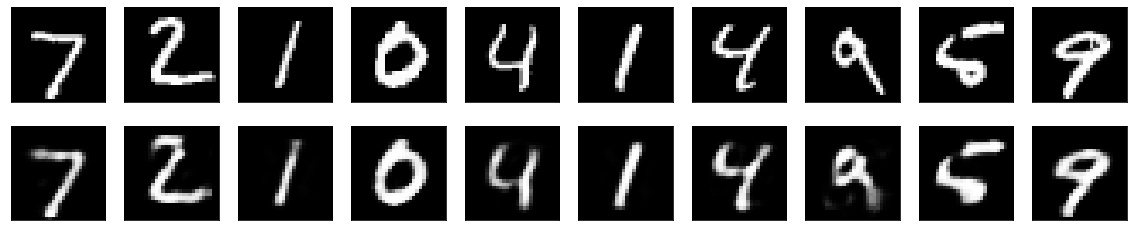

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
